# Import modules

In [1]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager

# Other
from tqdm import tqdm
import os

# Graphics
from matplotlib import pyplot as plt
import seaborn as sns

# Additional modules
from dataset_creator import generate_csv
from math import floor

sns.set()

d:\projects\.venvs\ml_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define constants

In [2]:
datasets_path = r"..\datasets\csv_files"
img_path = r"..\datasets\images"
models_path = r"..\models"

# Generate Dataset

In [3]:
create_dataset = False
if create_dataset:
    generate_csv(win_size=13, dump_to_file=5000, step=5)

# Create DataLoader

In [4]:
""" Will be done in the future """
# class CustomDataLoader:
#     def __init__(self, datasets_path, dataset_name, batch_size, split_size, state) -> None:
#         self.datasets_path = datasets_path
#         self.dataset_name = dataset_name
#         self.main_path = f"{datasets_path}\{dataset_name}"
        
#         self.batch_size = batch_size
#         self.split_size = split_size
        
#         self.test_batches, self.real_test_samples = self.get_test_amount()
#         self.skip_rows = self.real_test_samples
        
#         self.state = state
#         self.counter = 1

#     def __iter__(self):
#         if self.state == "Train":
#             self.train = pd.read_csv(self.main_path, chunksize=self.batch_size,
#                                     header=None, index_col=None, iterator=True)
#             return self.train
#         else:
#             self.test = pd.read_csv(self.main_path, chunksize=self.batch_size,
#                                     header=None, index_col=None, iterator=True,
#                                     skiprows=self.skip_rows)
#             return self.test

#     def __next__(self):
#         print(f"{self.state = }, {self.test_batches = }")
#         if self.state == "Train":
#             self.counter += 1
#             if self.counter >= self.test_batches:
#                 print("StopIteration")
#                 raise StopIteration
            
#             return self.chunk.get_chunk()
#         return self.chunk.get_chunk()
        

#     def get_len_data(self ) -> int:
#         idx_start = self.dataset_name.find("L") + 1
#         idx_finish = self.dataset_name.find(".")
#         length = int(self.dataset_name[idx_start:idx_finish])
#         return length
    
#     def get_test_amount(self) -> tuple:
#         length = self.get_len_data()
#         test_smaples = int(length * self.split_size)
#         test_batches = floor(test_smaples / self.batch_size)
#         real_test_samples = test_batches * self.batch_size
#         print(f"{length = }, {test_batches = }, {real_test_samples = }")
#         return test_batches, real_test_samples
    
    
# train = CustomDataLoader(datasets_path=datasets_path,
#                      dataset_name="tmp_L6.csv",
#                      batch_size=2,
#                      split_size=0.5,
#                      state="Train")
# test = CustomDataLoader(datasets_path=datasets_path,
#                      dataset_name="tmp_L6.csv",
#                      batch_size=2,
#                      split_size=0.5,
#                      state="Test")
# for i in train:
#     display(i)
# print("=" * 20)
# for i in test:
#     display(i)


' Will be done in the future '

In [5]:
class DefaultDL(Dataset):
    def __init__(self, dataset_path, dataset_name):
        super().__init__()
        main_path = f"{dataset_path}\{dataset_name}"
        self.data = pd.read_csv(main_path, header=None)

        target_ind = self.data.shape[1] - 1
        self.data.rename(columns={target_ind: "target"}, inplace=True)

        self.targets = self.data["target"]
        self.data.drop(columns="target", inplace=True)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        x = torch.Tensor(self.data.iloc[index].to_numpy()).float()
        y = torch.Tensor([self.targets.iloc[index]]).float()
        return x, y

## Load dataset

In [6]:
dataset_name = r"W13_S5_L146410.csv"
win_size = 13
batch_size = 64

In [7]:
dataset = DefaultDL(datasets_path, dataset_name)

In [8]:
train_size = int(dataset.__len__() * 0.8)
test_size = dataset.__len__() - train_size
print(f"{train_size = }\n{test_size = },\n{train_size + test_size = }")

train_size = 117128
test_size = 29282,
train_size + test_size = 146410


In [9]:
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

d:\projects\.venvs\ml_venv\lib\site-packages\torch\utils\data\dataset.py:313: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  indices = randperm(sum(lengths), generator=generator).tolist()


# NN Model

In [10]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        self.hid_n = 450
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.hid_n * 2),
            nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            # nn.Linear(self.hid_n, self.hid_n),
            # nn.BatchNorm1d(self.hid_n),
            # nn.ReLU(),
            # nn.Linear(self.hid_n, self.hid_n),
            # nn.BatchNorm1d(self.hid_n),
            # nn.ReLU(),
            nn.Linear(self.hid_n, self.out_len),
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

## Define NN's constants

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.0005
num_epoches = 2

## Initialize model

In [12]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
losses = []
losses_append = losses.append

valid_losses = []
valid_losses_append = valid_losses.append

for epoch in range(num_epoches):
    model.train()
    for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
        # Data on cuda
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        if batch_ind % 3 == 0:
            losses_append(loss.item())
        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            # Forward
            scores = model(data) # Equal to model.forward(data)
            loss = criterion(scores, targets)
            valid_losses_append(loss.item())
            

0it [00:00, ?it/s]


RuntimeError: running_mean should contain 900 elements not 450

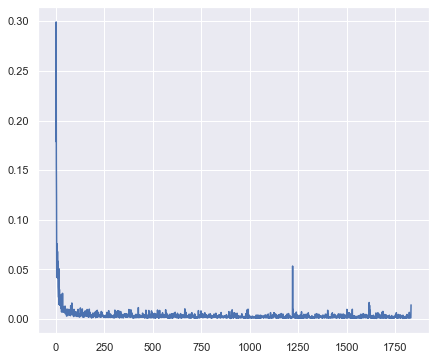

In [ ]:
sns.set(rc={"figure.figsize": (7, 6)})
plt.plot(losses);

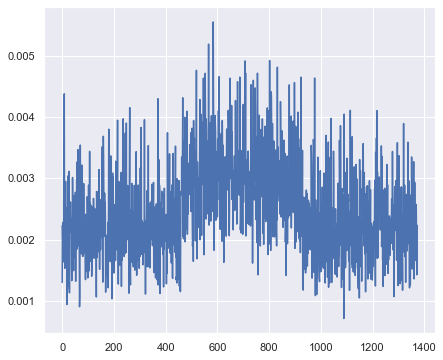

In [ ]:
sns.set(rc={"figure.figsize": (7, 6)})
plt.plot(valid_losses);

In [ ]:
checkpoint = {"state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
              'loss': loss}
torch.save(checkpoint, f"{models_path}\DefaultModel_{win_size}_S5.pt")


# Check NN works

In [ ]:
from image_processing import add_noise, add_borders
from os import listdir
from PIL import Image, ImageOps
import numpy as np

In [ ]:

datasets_path
src_images = r"D:\projects\NIR\datasets\images"
imgs_with_noise = r"D:\projects\NIR\datasets\imgs_with_noise"
def create_grayscale_imgs():
    for image_name in listdir(src_images):
        img = ImageOps.grayscale(Image.open(f"{src_images}\{image_name}"))
        img = np.array(img)
        
        img = add_noise(img)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        img.save(f"{imgs_with_noise}\{image_name}")


In [ ]:
img_name = "2.jpg"
img = ImageOps.grayscale(Image.open(f"{imgs_with_noise}\{img_name}"))
out = np.empty(img.size)
half_win_size = win_size // 2
img_with_borders = np.array(add_borders(img, win_size=11)) / 255
model.eval()
with torch.no_grad():
    for y in range(img.size[0]):
        for x in range(img.size[1]):
            croped_img = torch.Tensor([img_with_borders[y:win_size+y, x:win_size+x].flatten()]).float()
            res = model(croped_img)
            # break
            out[y, x] = res
out *= 255
out = np.where(out <= 255, out, 255)
# img = out.astype(np.uint8)
# img = Image.fromarray(img)
        

In [ ]:
img = out.astype(np.uint8)
img = Image.fromarray(img)
img.show()
img_name = "2.jpg"
img.save(fr"D:\projects\NIR\datasets\filtered_imgs\{img_name}")

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

In [ ]:
filtered_img = np.array(ImageOps.grayscale(Image.open(fr"D:\projects\NIR\datasets\filtered_imgs\{img_name}")))
genuine_image = np.array(ImageOps.grayscale(Image.open(fr"D:\projects\NIR\datasets\images\{img_name}")))
ssim_val = ssim(filtered_img, genuine_image)
mse_val = mse(filtered_img, genuine_image)
print(f"SSIM = {round(ssim_val, 2)}")
print(f"MSE = {round(mse_val, 2)}")

SSIM = 0.38
MSE = 1776.27
